In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import pickle
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional, Dense, Dropout,
    BatchNormalization, Concatenate, GlobalMaxPooling1D,
    GlobalAveragePooling1D, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import ast

In [ ]:
# Load preprocessed datasets
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/banking_train_processed.csv')

test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/banking_test_processed.csv')

print("✅ Data loaded successfully!")
print(f"Training shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")

✅ Data loaded successfully!
Training shape: (10003, 11)
Test shape: (3080, 11)


In [ ]:
# Load tokenizer
with open('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/banking_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [ ]:
# Convert tokenized sequences back to arrays
train_sequences = np.array([ast.literal_eval(seq) for seq in train_data['tokenized_sequences']])
test_sequences = np.array([ast.literal_eval(seq) for seq in test_data['tokenized_sequences']])

print(f"Training sequences shape: {train_sequences.shape}")
print(f"Test sequences shape: {test_sequences.shape}")

Training sequences shape: (10003, 14)
Test sequences shape: (3080, 14)


In [ ]:
# Prepare labels for multi-task learning
def prepare_labels(data):
    """Prepare labels for hierarchical multi-task learning"""

    # Category labels (Level 1: 4 classes)
    category_encoder = LabelEncoder()
    category_labels = category_encoder.fit_transform(data['category'])

    # Intent labels (Level 2: 77 classes)
    intent_encoder = LabelEncoder()
    intent_labels = intent_encoder.fit_transform(data['label_text'])

    # Urgency labels (Level 3: 3 classes)
    urgency_encoder = LabelEncoder()
    urgency_labels = urgency_encoder.fit_transform(data['urgency'])

    return {
        'category': category_labels,
        'intent': intent_labels,
        'urgency': urgency_labels
    }, {
        'category_encoder': category_encoder,
        'intent_encoder': intent_encoder,
        'urgency_encoder': urgency_encoder
    }

In [ ]:
# Prepare training labels
train_labels, label_encoders = prepare_labels(train_data)
test_labels, _ = prepare_labels(test_data)

print(f"Category classes: {len(label_encoders['category_encoder'].classes_)}")
print(f"Intent classes: {len(label_encoders['intent_encoder'].classes_)}")
print(f"Urgency classes: {len(label_encoders['urgency_encoder'].classes_)}")

Category classes: 4
Intent classes: 77
Urgency classes: 3


In [ ]:
# Create train/validation split from training data
X_train, X_val, y_train_cat, y_val_cat = train_test_split(
    train_sequences, train_labels['category'],
    test_size=0.2, random_state=42, stratify=train_labels['category']
)

_, _, y_train_intent, y_val_intent = train_test_split(
    train_sequences, train_labels['intent'],
    test_size=0.2, random_state=42, stratify=train_labels['category']
)

_, _, y_train_urgency, y_val_urgency = train_test_split(
    train_sequences, train_labels['urgency'],
    test_size=0.2, random_state=42, stratify=train_labels['category']
)

In [ ]:
# Organize training and validation data
train_targets = {
    'category_output': y_train_cat,
    'intent_output': y_train_intent,
    'urgency_output': y_train_urgency
}

val_targets = {
    'category_output': y_val_cat,
    'intent_output': y_val_intent,
    'urgency_output': y_val_urgency
}

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")


Training set: 8002 samples
Validation set: 2001 samples


In [ ]:
 #Display category distribution
print(f"\nCategory distribution:")
for i, category in enumerate(label_encoders['category_encoder'].classes_):
    count = np.sum(train_labels['category'] == i)
    print(f"  {category}: {count} samples")


Category distribution:
  Account Management: 1140 samples
  Card Services: 4416 samples
  General Support: 573 samples
  Transfer & Payments: 3874 samples


In [ ]:
import numpy as np
import random
import tensorflow as tf


# Set random seeds for reproducibility

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
#==========Defining the Hierarchical 3-Headed Multi-Task Neural Network model's blueprints (Purpose: Encapsulate everything about the model in one reusable class)===========


class Hierarchical3HeadedBankingModel:
    """Hierarchical 3-Headed Multi-Task Neural Network for Banking Automation"""

    def __init__(self, vocab_size, max_length, embedding_dim=128):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.embedding_dim = embedding_dim
        self.model = None

    def build_model(self):
        """Build the complete 3-headed hierarchical architecture"""

        print("🏗️ Building 3-Headed Hierarchical Architecture...")

        # Input layer
        input_text = Input(shape=(self.max_length,), name='text_input')

        # Shared embedding layer
        embedding = Embedding(
            input_dim=self.vocab_size,
            output_dim=self.embedding_dim,
            input_length=self.max_length,
            mask_zero=True,
            name='shared_embedding'
        )(input_text)

        # Shared feature extraction layers
        print("   🔧 Building shared LSTM layers...")
        lstm1 = Bidirectional(
            LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
            name='shared_lstm1'
        )(embedding)

        lstm2 = Bidirectional(
            LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
            name='shared_lstm2'
        )(lstm1)

        # Global pooling for feature aggregation # concatenating both max & Ave vectors improves performance because some tasks rely on strong keywords, others on overall context.
        global_max = GlobalMaxPooling1D(name='global_max')(lstm2)
        global_avg = GlobalAveragePooling1D(name='global_avg')(lstm2)

        # Combine pooled features
        shared_features = Concatenate(name='shared_features')([global_max, global_avg])
        shared_features = BatchNormalization(name='shared_batch_norm')(shared_features)
        shared_features = Dropout(0.5, name='shared_dropout')(shared_features)

        # Dense feature representation
        shared_dense = Dense(256, activation='relu', name='shared_dense')(shared_features)
        shared_dense = BatchNormalization(name='shared_dense_bn')(shared_dense)
        shared_dense = Dropout(0.4, name='shared_dense_dropout')(shared_dense)

        # ============= HEAD 1: CATEGORY CLASSIFICATION =============
        print("   📊 Head 1: Category Classification")
        category_branch = Dense(128, activation='relu', name='category_branch')(shared_dense)
        category_branch = BatchNormalization(name='category_bn')(category_branch)
        category_branch = Dropout(0.3, name='category_dropout')(category_branch)
        category_features = Dense(64, activation='relu', name='category_features')(category_branch)
        category_output = Dense(4, activation='softmax', name='category_output')(category_features)

        # ============= HEAD 2: SPECIALIZED INTENT BRANCHES =============
        print("   🎯 Head 2: Specialized Intent Classification")

        # Card Branch (for card-related intents)
        card_branch = Dense(128, activation='relu', name='card_branch')(shared_dense)
        card_branch = BatchNormalization(name='card_bn')(card_branch)
        card_branch = Dropout(0.3, name='card_dropout')(card_branch)
        card_features = Dense(64, activation='relu', name='card_features')(card_branch)

        # Account Branch (for account-related intents)
        account_branch = Dense(128, activation='relu', name='account_branch')(shared_dense)
        account_branch = BatchNormalization(name='account_bn')(account_branch)
        account_branch = Dropout(0.3, name='account_dropout')(account_branch)
        account_features = Dense(64, activation='relu', name='account_features')(account_branch)

        # Transfer Branch (for transfer-related intents)
        transfer_branch = Dense(128, activation='relu', name='transfer_branch')(shared_dense)
        transfer_branch = BatchNormalization(name='transfer_bn')(transfer_branch)
        transfer_branch = Dropout(0.3, name='transfer_dropout')(transfer_branch)
        transfer_features = Dense(64, activation='relu', name='transfer_features')(transfer_branch)

        # Support Branch (for general support intents)
        support_branch = Dense(128, activation='relu', name='support_branch')(shared_dense)
        support_branch = BatchNormalization(name='support_bn')(support_branch)
        support_branch = Dropout(0.3, name='support_dropout')(support_branch)
        support_features = Dense(64, activation='relu', name='support_features')(support_branch)

        # Combine specialized branches with hierarchical context
        hierarchical_context = Concatenate(name='hierarchical_context')([
            shared_dense, category_features  # Include category context
        ])

        # Combine all specialized features
        combined_intent_features = Concatenate(name='combined_intent_features')([
            card_features, account_features, transfer_features, support_features
        ])

        # Merge for intent prediction
        intent_context = Concatenate(name='intent_context')([
            hierarchical_context, combined_intent_features
        ])

        # Intent classification layers
        intent_dense = Dense(256, activation='relu', name='intent_dense')(intent_context)
        intent_dense = BatchNormalization(name='intent_bn')(intent_dense)
        intent_dense = Dropout(0.3, name='intent_dropout')(intent_dense)

        intent_final = Dense(128, activation='relu', name='intent_final')(intent_dense)
        intent_output = Dense(77, activation='softmax', name='intent_output')(intent_final)

        # ============= HEAD 3: URGENCY CLASSIFICATION =============
        print("   ⚡ Head 3: Urgency Classification with Hierarchical Context")

        # Use hierarchical context (shared + category + intent information)
        urgency_context = Concatenate(name='urgency_context')([
            shared_dense, category_features, intent_dense  # Use all hierarchical info
        ])

        urgency_branch = Dense(128, activation='relu', name='urgency_branch')(urgency_context)
        urgency_branch = BatchNormalization(name='urgency_bn')(urgency_branch)
        urgency_branch = Dropout(0.3, name='urgency_dropout')(urgency_branch)

        urgency_features = Dense(64, activation='relu', name='urgency_features')(urgency_branch)
        urgency_output = Dense(3, activation='softmax', name='urgency_output')(urgency_features)

        # ============= CREATE 3-HEADED MODEL =============
        self.model = Model(
            inputs=input_text,
            outputs=[category_output, intent_output, urgency_output],
            name='Hierarchical3HeadedBankingModel'
        )

        print("✅ Complete 3-Headed Hierarchical Architecture Built!")
        return self.model

In [ ]:
# Model parameters
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
max_length = train_sequences.shape[1]

print(f"\nModel Parameters:")
print(f" Vocabulary size: {vocab_size}")
print(f" Max sequence length: {max_length}")
print(f" Embedding dimension: 128")


Model Parameters:
 Vocabulary size: 2297
 Max sequence length: 14
 Embedding dimension: 128


# Learning rate Comparison

In [ ]:
print("\n" + "="*80)
print("LEARNING RATE COMPARISON")
print("="*80)
print("Testing 3 learning rates: 0.0005, 0.001, 0.002")
print("="*80)

# Define Google Drive save directory
save_dir = '/content/drive/MyDrive/Colab Notebooks/AI_CW_010/Hyperparameter_comparison/Learning_Rate/'
os.makedirs(save_dir, exist_ok=True)

# Learning rates to test
learning_rates = [0.0005, 0.001, 0.002]
adam_results = {}



LEARNING RATE COMPARISON
Testing 3 learning rates: 0.0005, 0.001, 0.002


Learning rate = 0.0005

In [ ]:

# LEARNING RATE 1: 0.0005


print("\n" + "🔴 TESTING WITH LEARNING RATE: 0.0005" )
print("-" * 70)

# Create fresh model
banking_model_adam_0005 = Hierarchical3HeadedBankingModel(
    vocab_size=vocab_size,
    max_length=max_length,
    embedding_dim=128
)

model_adam_0005 = banking_model_adam_0005.build_model()
print(f"✅ Model built with {model_adam_0005.count_params():,} parameters")

# Compile with Adam lr=0.0005
adam_optimizer_0005 = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

model_adam_0005.compile(
    optimizer=adam_optimizer_0005,
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'intent_output': 'sparse_categorical_crossentropy',
        'urgency_output': 'sparse_categorical_crossentropy'
    },
    loss_weights={'category_output': 1.0, 'intent_output': 2.0, 'urgency_output': 1.5},
    metrics={'category_output': ['accuracy'], 'intent_output': ['accuracy'], 'urgency_output': ['accuracy']}
)

# CALLBACKS
callbacks_0005 = [
    EarlyStopping(
        monitor='val_intent_output_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        f'{save_dir}best_adam_lr_0005.keras',
        monitor='val_intent_output_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_intent_output_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-8,
        verbose=1,
        mode='max'
    )
]

# Train
print("🚀 Training with lr=0.0005...")
start_time = time.time()

history_adam_0005 = model_adam_0005.fit(
    X_train, train_targets,
    validation_data=(X_val, val_targets),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_0005,
    verbose=1
)

adam_0005_time = time.time() - start_time

#GET FINAL ACCURACIES FOR ALL 3 TASKS
print("📊 Evaluating final performance...")
final_eval_0005 = model_adam_0005.evaluate(X_val, val_targets, verbose=0)

# Extract all metrics
adam_0005_final_loss = final_eval_0005[0]
adam_0005_final_category_acc = final_eval_0005[4]
adam_0005_final_intent_acc = final_eval_0005[5]
adam_0005_final_urgency_acc = final_eval_0005[6]

adam_0005_best_intent_acc = max(history_adam_0005.history['val_intent_output_accuracy'])
adam_0005_best_category_acc = max(history_adam_0005.history['val_category_output_accuracy'])
adam_0005_best_urgency_acc = max(history_adam_0005.history['val_urgency_output_accuracy'])

adam_0005_best_epoch = history_adam_0005.history['val_intent_output_accuracy'].index(adam_0005_best_intent_acc) + 1

print(f"✅ Training completed in {adam_0005_time:.2f} seconds")
print(f"🎯 Best Intent Accuracy: {adam_0005_best_intent_acc:.4f}")
print(f"📊 Final Accuracies - Category: {adam_0005_final_category_acc:.4f}, Intent: {adam_0005_final_intent_acc:.4f}, Urgency: {adam_0005_final_urgency_acc:.4f}")


🔴 TESTING WITH LEARNING RATE: 0.0005
----------------------------------------------------------------------
🏗️ Building 3-Headed Hierarchical Architecture...
   🔧 Building shared LSTM layers...
   📊 Head 1: Category Classification
   🎯 Head 2: Specialized Intent Classification
   ⚡ Head 3: Urgency Classification with Hierarchical Context
✅ Complete 3-Headed Hierarchical Architecture Built!
✅ Model built with 1,272,340 parameters
🚀 Training with lr=0.0005...
Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - category_output_accuracy: 0.3993 - category_output_loss: 1.4260 - intent_output_accuracy: 0.0211 - intent_output_loss: 4.6239 - loss: 12.5729 - urgency_output_accuracy: 0.4605 - urgency_output_loss: 1.2660
Epoch 1: val_intent_output_accuracy improved from -inf to 0.01049, saving model to /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Hyperparameter_comparison/Learning_Rate/best_adam_lr_0005.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 87s 194ms/step - category_output_accuracy: 0.3997 

In [ ]:
# Save model and components
adam_0005_model_path = f'{save_dir}hierarchical_banking_model_adam_lr_0005.keras'
model_adam_0005.save(adam_0005_model_path)

adam_0005_encoders_path = f'{save_dir}label_encoders_adam_lr_0005.pkl'
with open(adam_0005_encoders_path, 'wb') as f:
    pickle.dump(label_encoders, f)

#  RESULTS STORAGE
adam_results['lr_0.0005'] = {
    'learning_rate': 0.0005,
    # Best accuracies (from training history)
    'best_intent_accuracy': adam_0005_best_intent_acc,
    'best_category_accuracy': adam_0005_best_category_acc,
    'best_urgency_accuracy': adam_0005_best_urgency_acc,
    # Final accuracies (from final evaluation)
    'final_intent_accuracy': adam_0005_final_intent_acc,
    'final_category_accuracy': adam_0005_final_category_acc,
    'final_urgency_accuracy': adam_0005_final_urgency_acc,
    'final_loss': adam_0005_final_loss,
    # Training metrics
    'training_time': adam_0005_time,
    'best_epoch': adam_0005_best_epoch,
    'total_epochs': len(history_adam_0005.history['loss']),
    # Additional analysis
    'convergence_efficiency': adam_0005_best_epoch / len(history_adam_0005.history['loss']),
    'training_stability': np.std(history_adam_0005.history['val_intent_output_accuracy'][-10:])
}

# Save detailed info
adam_0005_info = {
    'optimizer': 'Adam',
    'learning_rate': 0.0005,
    'vocab_size': vocab_size,
    'max_length': max_length,
    'embedding_dim': 128,
    'num_categories': len(label_encoders['category_encoder'].classes_),
    'num_intents': len(label_encoders['intent_encoder'].classes_),
    'num_urgency_levels': len(label_encoders['urgency_encoder'].classes_),
    'total_parameters': model_adam_0005.count_params(),
    'training_epochs': len(history_adam_0005.history['loss']),
    'best_val_category_accuracy': adam_0005_best_category_acc,
    'best_val_intent_accuracy': adam_0005_best_intent_acc,
    'best_val_urgency_accuracy': adam_0005_best_urgency_acc,
    'final_val_category_accuracy': adam_0005_final_category_acc,
    'final_val_intent_accuracy': adam_0005_final_intent_acc,
    'final_val_urgency_accuracy': adam_0005_final_urgency_acc,
    'training_time_sec': adam_0005_time,
    'best_epoch': adam_0005_best_epoch
}

with open(f'{save_dir}model_info_adam_lr_0005.json', 'w') as f:
    json.dump(adam_0005_info, f, indent=2)

pd.DataFrame(history_adam_0005.history).to_csv(f'{save_dir}training_history_adam_lr_0005.csv', index=False)

print(f" lr=0.0005 files saved!")


 lr=0.0005 files saved!


In [ ]:
# Memory cleanup
del model_adam_0005, banking_model_adam_0005, history_adam_0005
import gc
gc.collect()

1445

Learning rate = 0.001

In [ ]:

# LEARNING RATE 2: 0.001


print("\n" + "TESTING WITH LEARNING RATE: 0.001 ")
print("-" * 70)

# Create fresh model
banking_model_adam_001 = Hierarchical3HeadedBankingModel(
    vocab_size=vocab_size,
    max_length=max_length,
    embedding_dim=128
)

model_adam_001 = banking_model_adam_001.build_model()
print(f"✅ Model built with {model_adam_001.count_params():,} parameters")

# Compile with Adam lr=0.001
adam_optimizer_001 = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

model_adam_001.compile(
    optimizer=adam_optimizer_001,
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'intent_output': 'sparse_categorical_crossentropy',
        'urgency_output': 'sparse_categorical_crossentropy'
    },
    loss_weights={'category_output': 1.0, 'intent_output': 2.0, 'urgency_output': 1.5},
    metrics={'category_output': ['accuracy'], 'intent_output': ['accuracy'], 'urgency_output': ['accuracy']}
)

# CALLBACKS
callbacks_001 = [
    EarlyStopping(
        monitor='val_intent_output_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        f'{save_dir}best_adam_lr_001.keras',
        monitor='val_intent_output_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_intent_output_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-8,
        verbose=1,
        mode='max'
    )
]

# Train
print("🚀 Training with lr=0.001...")
start_time = time.time()

history_adam_001 = model_adam_001.fit(
    X_train, train_targets,
    validation_data=(X_val, val_targets),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_001,
    verbose=1
)

adam_001_time = time.time() - start_time

# GET FINAL ACCURACIES FOR ALL 3 TASKS
print("📊 Evaluating final performance...")
final_eval_001 = model_adam_001.evaluate(X_val, val_targets, verbose=0)

# Extract all metrics
adam_001_final_loss = final_eval_001[0]
adam_001_final_category_acc = final_eval_001[4]
adam_001_final_intent_acc = final_eval_001[5]
adam_001_final_urgency_acc = final_eval_001[6]

adam_001_best_intent_acc = max(history_adam_001.history['val_intent_output_accuracy'])
adam_001_best_category_acc = max(history_adam_001.history['val_category_output_accuracy'])
adam_001_best_urgency_acc = max(history_adam_001.history['val_urgency_output_accuracy'])

adam_001_best_epoch = history_adam_001.history['val_intent_output_accuracy'].index(adam_001_best_intent_acc) + 1

print(f"✅ Training completed in {adam_001_time:.2f} seconds")
print(f"🎯 Best Intent Accuracy: {adam_001_best_intent_acc:.4f}")
print(f"📊 Final Accuracies - Category: {adam_001_final_category_acc:.4f}, Intent: {adam_001_final_intent_acc:.4f}, Urgency: {adam_001_final_urgency_acc:.4f}")



TESTING WITH LEARNING RATE: 0.001 
----------------------------------------------------------------------
🏗️ Building 3-Headed Hierarchical Architecture...
   🔧 Building shared LSTM layers...
   📊 Head 1: Category Classification
   🎯 Head 2: Specialized Intent Classification
   ⚡ Head 3: Urgency Classification with Hierarchical Context
✅ Complete 3-Headed Hierarchical Architecture Built!
✅ Model built with 1,272,340 parameters
🚀 Training with lr=0.001...
Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - category_output_accuracy: 0.4929 - category_output_loss: 1.2103 - intent_output_accuracy: 0.0323 - intent_output_loss: 4.4632 - loss: 11.8150 - urgency_output_accuracy: 0.4950 - urgency_output_loss: 1.1188
Epoch 1: val_intent_output_accuracy improved from -inf to 0.03298, saving model to /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Hyperparameter_comparison/Learning_Rate/best_adam_lr_001.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 86s 197ms/step - category_output_accuracy: 0.4933 - ca

In [ ]:
# ============= SAVE lr=0.001 MODEL AND COMPONENTS =============
print(f"\n💾 SAVING lr=0.001 MODEL AND COMPONENTS")
print("-" * 50)

# Save the trained model
adam_001_model_path = f'{save_dir}hierarchical_banking_model_adam_lr_001.keras'
model_adam_001.save(adam_001_model_path)
print(f"✅ Model saved: {adam_001_model_path}")

# Save label encoders
adam_001_encoders_path = f'{save_dir}label_encoders_adam_lr_001.pkl'
with open(adam_001_encoders_path, 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"✅ Label encoders saved: {adam_001_encoders_path}")

# Save model parameters & metadata
adam_001_info = {
    'optimizer': 'Adam',
    'learning_rate': 0.001,
    'vocab_size': vocab_size,
    'max_length': max_length,
    'embedding_dim': 128,
    'num_categories': len(label_encoders['category_encoder'].classes_),
    'num_intents': len(label_encoders['intent_encoder'].classes_),
    'num_urgency_levels': len(label_encoders['urgency_encoder'].classes_),
    'total_parameters': model_adam_001.count_params(),
    'training_epochs': len(history_adam_001.history['loss']),
    'best_val_category_accuracy': adam_001_best_category_acc,
    'best_val_intent_accuracy': adam_001_best_intent_acc,
    'best_val_urgency_accuracy': adam_001_best_urgency_acc,
    'final_val_category_accuracy': adam_001_final_category_acc,
    'final_val_intent_accuracy': adam_001_final_intent_acc,
    'final_val_urgency_accuracy': adam_001_final_urgency_acc,
    'training_time_sec': adam_001_time,
    'best_epoch': adam_001_best_epoch
}

adam_001_info_path = f'{save_dir}model_info_adam_lr_001.json'
with open(adam_001_info_path, 'w') as f:
    json.dump(adam_001_info, f, indent=2)
print(f"✅ Model info saved: {adam_001_info_path}")

#  Save training history
adam_001_history_path = f'{save_dir}training_history_adam_lr_001.csv'
pd.DataFrame(history_adam_001.history).to_csv(adam_001_history_path, index=False)
print(f"✅ Training history saved: {adam_001_history_path}")

#ENHANCED RESULTS STORAGE
adam_results['lr_0.001'] = {
    'learning_rate': 0.001,
    # Best accuracies (from training history)
    'best_intent_accuracy': adam_001_best_intent_acc,
    'best_category_accuracy': adam_001_best_category_acc,
    'best_urgency_accuracy': adam_001_best_urgency_acc,
    # Final accuracies (from final evaluation)
    'final_intent_accuracy': adam_001_final_intent_acc,
    'final_category_accuracy': adam_001_final_category_acc,
    'final_urgency_accuracy': adam_001_final_urgency_acc,
    'final_loss': adam_001_final_loss,
    # Training metrics
    'training_time': adam_001_time,
    'best_epoch': adam_001_best_epoch,
    'total_epochs': len(history_adam_001.history['loss']),
    # Additional analysis
    'convergence_efficiency': adam_001_best_epoch / len(history_adam_001.history['loss']),
    'training_stability': np.std(history_adam_001.history['val_intent_output_accuracy'][-10:])
}

print(f"🎯 lr=0.001 Results: Best Intent {adam_results['lr_0.001']['best_intent_accuracy']:.4f}, Final Intent {adam_results['lr_0.001']['final_intent_accuracy']:.4f}")
print(f"💾 All lr=0.001 files saved!")



💾 SAVING lr=0.001 MODEL AND COMPONENTS
--------------------------------------------------
✅ Model saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Hyperparameter_comparison/Learning_Rate/hierarchical_banking_model_adam_lr_001.keras
✅ Label encoders saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Hyperparameter_comparison/Learning_Rate/label_encoders_adam_lr_001.pkl
✅ Model info saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Hyperparameter_comparison/Learning_Rate/model_info_adam_lr_001.json
✅ Training history saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Hyperparameter_comparison/Learning_Rate/training_history_adam_lr_001.csv
🎯 lr=0.001 Results: Best Intent 0.8371, Final Intent 0.8371
💾 All lr=0.001 files saved!


In [ ]:
# Memory cleanup
del model_adam_001, banking_model_adam_001, history_adam_001
import gc
gc.collect()

1631

Learning Rate = 0.002

In [ ]:

# LEARNING RATE 3: 0.002


print("\n" + "🔴 TESTING WITH LEARNING RATE: 0.002")
print("-" * 70)

# Create fresh model
banking_model_adam_002 = Hierarchical3HeadedBankingModel(
    vocab_size=vocab_size,
    max_length=max_length,
    embedding_dim=128
)

model_adam_002 = banking_model_adam_002.build_model()
print(f"✅ Model built with {model_adam_002.count_params():,} parameters")

# Compile with Adam lr=0.002
adam_optimizer_002 = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

model_adam_002.compile(
    optimizer=adam_optimizer_002,
    loss={
        'category_output': 'sparse_categorical_crossentropy',
        'intent_output': 'sparse_categorical_crossentropy',
        'urgency_output': 'sparse_categorical_crossentropy'
    },
    loss_weights={'category_output': 1.0, 'intent_output': 2.0, 'urgency_output': 1.5},
    metrics={'category_output': ['accuracy'], 'intent_output': ['accuracy'], 'urgency_output': ['accuracy']}
)

# CALLBACKS
callbacks_002 = [
    EarlyStopping(
        monitor='val_intent_output_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        f'{save_dir}best_adam_lr_002.keras',
        monitor='val_intent_output_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_intent_output_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-8,
        verbose=1,
        mode='max'
    )
]

# Train
print("🚀 Training with lr=0.002...")
start_time = time.time()

history_adam_002 = model_adam_002.fit(
    X_train, train_targets,
    validation_data=(X_val, val_targets),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_002,
    verbose=1
)

adam_002_time = time.time() - start_time

# GET FINAL ACCURACIES FOR ALL 3 TASKS
print("📊 Evaluating final performance...")
final_eval_002 = model_adam_002.evaluate(X_val, val_targets, verbose=0)

# Extract all metrics
adam_002_final_loss = final_eval_002[0]
adam_002_final_category_acc = final_eval_002[4]
adam_002_final_intent_acc = final_eval_002[5]
adam_002_final_urgency_acc = final_eval_002[6]

adam_002_best_intent_acc = max(history_adam_002.history['val_intent_output_accuracy'])
adam_002_best_category_acc = max(history_adam_002.history['val_category_output_accuracy'])
adam_002_best_urgency_acc = max(history_adam_002.history['val_urgency_output_accuracy'])

adam_002_best_epoch = history_adam_002.history['val_intent_output_accuracy'].index(adam_002_best_intent_acc) + 1

print(f"✅ Training completed in {adam_002_time:.2f} seconds")
print(f"🎯 Best Intent Accuracy: {adam_002_best_intent_acc:.4f}")
print(f"📊 Final Accuracies - Category: {adam_002_final_category_acc:.4f}, Intent: {adam_002_final_intent_acc:.4f}, Urgency: {adam_002_final_urgency_acc:.4f}")



🔴 TESTING WITH LEARNING RATE: 0.002
----------------------------------------------------------------------
🏗️ Building 3-Headed Hierarchical Architecture...
   🔧 Building shared LSTM layers...
   📊 Head 1: Category Classification
   🎯 Head 2: Specialized Intent Classification
   ⚡ Head 3: Urgency Classification with Hierarchical Context
✅ Complete 3-Headed Hierarchical Architecture Built!
✅ Model built with 1,272,340 parameters
🚀 Training with lr=0.002...
Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - category_output_accuracy: 0.5131 - category_output_loss: 1.1758 - intent_output_accuracy: 0.0514 - intent_output_loss: 4.3245 - loss: 11.4703 - urgency_output_accuracy: 0.5195 - urgency_output_loss: 1.0970
Epoch 1: val_intent_output_accuracy improved from -inf to 0.05147, saving model to /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Hyperparameter_comparison/Learning_Rate/best_adam_lr_002.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 88s 214ms/step - category_output_accuracy: 0.5136 - c

In [ ]:
# ============= SAVE  lr=0.002 MODEL AND COMPONENTS =============
print(f"\n💾 SAVING  lr=0.002 MODEL AND COMPONENTS")
print("-" * 50)

# Save the trained model
adam_002_model_path = f'{save_dir}hierarchical_banking_model_adam_lr_002.keras'
model_adam_002.save(adam_002_model_path)
print(f"✅ Model saved: {adam_002_model_path}")

# Save label encoders
adam_002_encoders_path = f'{save_dir}label_encoders_adam_lr_002.pkl'
with open(adam_002_encoders_path, 'wb') as f:
    pickle.dump(label_encoders, f)
print(f"✅ Label encoders saved: {adam_002_encoders_path}")

# Save model parameters & metadata
adam_002_info = {
    'optimizer': 'Adam',
    'learning_rate': 0.002,
    'vocab_size': vocab_size,
    'max_length': max_length,
    'embedding_dim': 128,
    'num_categories': len(label_encoders['category_encoder'].classes_),
    'num_intents': len(label_encoders['intent_encoder'].classes_),
    'num_urgency_levels': len(label_encoders['urgency_encoder'].classes_),
    'total_parameters': model_adam_002.count_params(),
    'training_epochs': len(history_adam_002.history['loss']),
    'best_val_category_accuracy': adam_002_best_category_acc,
    'best_val_intent_accuracy': adam_002_best_intent_acc,
    'best_val_urgency_accuracy': adam_002_best_urgency_acc,
    'final_val_category_accuracy': adam_002_final_category_acc,
    'final_val_intent_accuracy': adam_002_final_intent_acc,
    'final_val_urgency_accuracy': adam_002_final_urgency_acc,
    'training_time_sec': adam_002_time,
    'best_epoch': adam_002_best_epoch
}

adam_002_info_path = f'{save_dir}model_info_adam_lr_002.json'
with open(adam_002_info_path, 'w') as f:
    json.dump(adam_002_info, f, indent=2)
print(f"✅ Model info saved: {adam_002_info_path}")

# 4️⃣ Save training history
adam_002_history_path = f'{save_dir}training_history_adam_lr_002.csv'
pd.DataFrame(history_adam_002.history).to_csv(adam_002_history_path, index=False)
print(f"✅ Training history saved: {adam_002_history_path}")

#ENHANCED RESULTS STORAGE
adam_results['lr_0.002'] = {
    'learning_rate': 0.002,
    # Best accuracies (from training history)
    'best_intent_accuracy': adam_002_best_intent_acc,
    'best_category_accuracy': adam_002_best_category_acc,
    'best_urgency_accuracy': adam_002_best_urgency_acc,
    # Final accuracies (from final evaluation)
    'final_intent_accuracy': adam_002_final_intent_acc,
    'final_category_accuracy': adam_002_final_category_acc,
    'final_urgency_accuracy': adam_002_final_urgency_acc,
    'final_loss': adam_002_final_loss,
    # Training metrics
    'training_time': adam_002_time,
    'best_epoch': adam_002_best_epoch,
    'total_epochs': len(history_adam_002.history['loss']),
    # Additional analysis
    'convergence_efficiency': adam_002_best_epoch / len(history_adam_002.history['loss']),
    'training_stability': np.std(history_adam_002.history['val_intent_output_accuracy'][-10:])
}

print(f"🎯 lr=0.002 Results: Best Intent {adam_results['lr_0.002']['best_intent_accuracy']:.4f}, Final Intent {adam_results['lr_0.002']['final_intent_accuracy']:.4f}")
print(f"💾 All lr=0.002 files saved!")


💾 SAVING  lr=0.002 MODEL AND COMPONENTS
--------------------------------------------------
✅ Model saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Hyperparameter_comparison/Learning_Rate/hierarchical_banking_model_adam_lr_002.keras
✅ Label encoders saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Hyperparameter_comparison/Learning_Rate/label_encoders_adam_lr_002.pkl
✅ Model info saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Hyperparameter_comparison/Learning_Rate/model_info_adam_lr_002.json
✅ Training history saved: /content/drive/MyDrive/Colab Notebooks/AI_CW_010/Hyperparameter_comparison/Learning_Rate/training_history_adam_lr_002.csv
🎯 lr=0.002 Results: Best Intent 0.8451, Final Intent 0.8451
💾 All lr=0.002 files saved!


In [ ]:
# Memory cleanup
del model_adam_002, banking_model_adam_002, history_adam_002
gc.collect()

1038

# Analysis of 3 learning rates

In [ ]:
# REBUILD ADAM RESULTS DICTIONARY FROM SAVED FILES


import json

# Paths to saved info files
info_files = {
    "lr_0.0005": f"{save_dir}model_info_adam_lr_0005.json",
    "lr_0.001": f"{save_dir}model_info_adam_lr_001.json",
    "lr_0.002": f"{save_dir}model_info_adam_lr_002.json"
}

# Load each JSON back into a dictionary
adam_results = {}
for key, file in info_files.items():
    with open(file, "r") as f:
        adam_results[key] = json.load(f)

print("Loaded learning rate results:", adam_results.keys())


Loaded learning rate results: dict_keys(['lr_0.0005', 'lr_0.001', 'lr_0.002'])


Full comparison DataFrame

In [ ]:
# Convert adam_results into a DataFrame for easy viewing
lr_comparison_df = pd.DataFrame(adam_results).T  # transpose so lr values are rows
display(lr_comparison_df.head())


,optimizer,learning_rate,vocab_size,max_length,embedding_dim,num_categories,num_intents,num_urgency_levels,total_parameters,training_epochs,best_val_category_accuracy,best_val_intent_accuracy,best_val_urgency_accuracy,final_val_category_accuracy,final_val_intent_accuracy,final_val_urgency_accuracy,training_time_sec,best_epoch
lr_0.0005,Adam,0.0005,2297,14,128,4,77,3,1272340,50,0.943528,0.832584,0.77911,0.93903,0.832584,0.77911,3495.649842,48
lr_0.001,Adam,0.001,2297,14,128,4,77,3,1272340,50,0.942029,0.837081,0.766117,0.937032,0.837081,0.757121,3404.443769,40
lr_0.002,Adam,0.002,2297,14,128,4,77,3,1272340,45,0.942529,0.845077,0.774613,0.934033,0.845077,0.762119,3058.798242,30


Table of Best & Final Accuracies

In [ ]:
best_vs_final = lr_comparison_df[[
    "best_val_category_accuracy", "final_val_category_accuracy",
    "best_val_intent_accuracy", "final_val_intent_accuracy",
    "best_val_urgency_accuracy", "final_val_urgency_accuracy"
]]

print("📊 Best vs Final Accuracy Comparison")
display(best_vs_final)


📊 Best vs Final Accuracy Comparison


,best_val_category_accuracy,final_val_category_accuracy,best_val_intent_accuracy,final_val_intent_accuracy,best_val_urgency_accuracy,final_val_urgency_accuracy
lr_0.0005,0.943528,0.93903,0.832584,0.832584,0.77911,0.77911
lr_0.001,0.942029,0.937032,0.837081,0.837081,0.766117,0.757121
lr_0.002,0.942529,0.934033,0.845077,0.845077,0.774613,0.762119


Bar Plot – Final Accuracy by Learning Rate

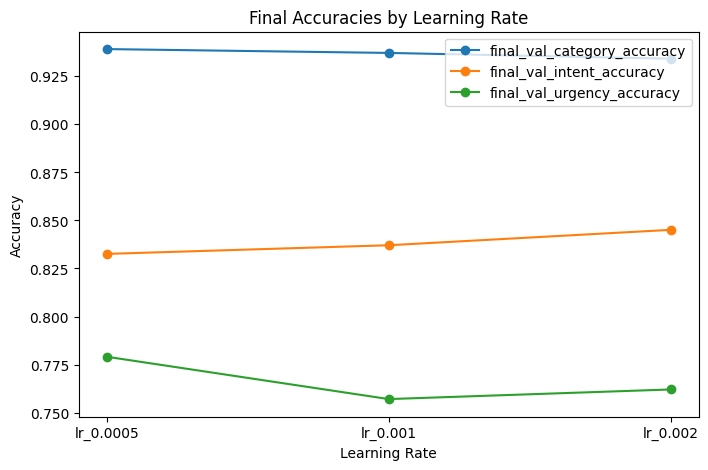

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for col in ["final_val_category_accuracy", "final_val_intent_accuracy", "final_val_urgency_accuracy"]:
    plt.plot(lr_comparison_df.index, lr_comparison_df[col], marker="o", label=col)

plt.title("Final Accuracies by Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Training Time vs Accuracy

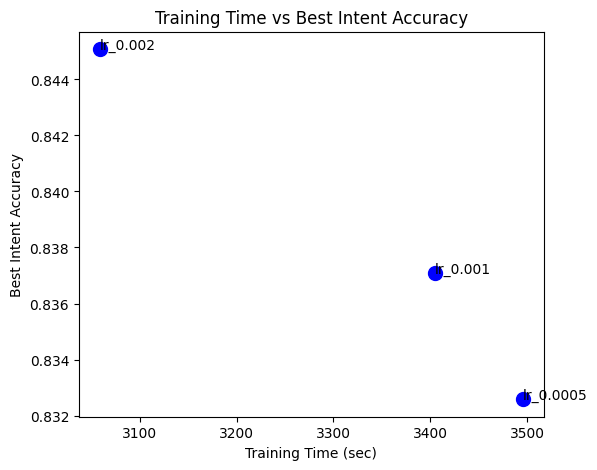

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(
    lr_comparison_df["training_time_sec"],
    lr_comparison_df["best_val_intent_accuracy"],
    s=100, c="blue"
)

for i, txt in enumerate(lr_comparison_df.index):
    plt.annotate(txt, (lr_comparison_df["training_time_sec"].iloc[i],
                       lr_comparison_df["best_val_intent_accuracy"].iloc[i]))

plt.title("Training Time vs Best Intent Accuracy")
plt.xlabel("Training Time (sec)")
plt.ylabel("Best Intent Accuracy")
plt.show()


Training History Curves

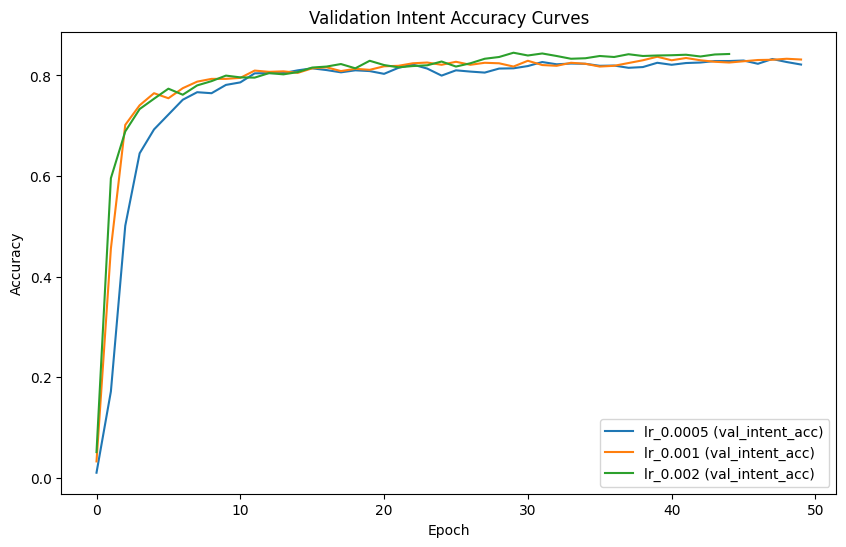

In [ ]:
history_files = {
    "lr_0.0005": f"{save_dir}training_history_adam_lr_0005.csv",
    "lr_0.001": f"{save_dir}training_history_adam_lr_001.csv",
    "lr_0.002": f"{save_dir}training_history_adam_lr_002.csv"
}

plt.figure(figsize=(10,6))
for key, file in history_files.items():
    history_df = pd.read_csv(file)
    plt.plot(history_df["val_intent_output_accuracy"], label=f"{key} (val_intent_acc)")

plt.title("Validation Intent Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Convergence efficiency

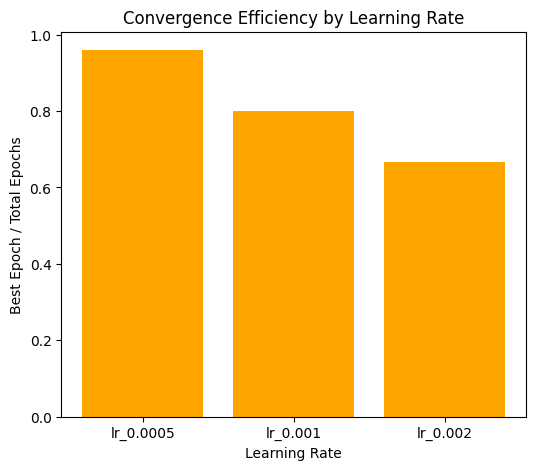

In [ ]:
# Add convergence_efficiency column manually
lr_comparison_df["convergence_efficiency"] = (
    lr_comparison_df["best_epoch"] / lr_comparison_df["training_epochs"]
)

plt.figure(figsize=(6,5))
plt.bar(lr_comparison_df.index, lr_comparison_df["convergence_efficiency"], color="orange")

plt.title("Convergence Efficiency by Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Best Epoch / Total Epochs")
plt.show()